# Tarea de Clustering

## Introducción
Esta tarea consiste en la implementación en python del algoritmo de k-means desde cero, tomando en cuenta las siguientes características:
<ol>
    <li>
        <strong>Comparación de implementaciones de k-means:</strong> Se ha realizado una comparación de los resultados obtenidos con el algoritmo implementado desde cero y el algoritmo que ofrece la librería <a href="https://scikit-learn.org/stable/">sickit-learn</a>.
    </li>
    <li>
        <strong>Comparación de algoritmos:</strong> Se ha realizado una comparación de resultados entre los algoritmos k-medoids y k-means.
    </li>
    <li>
        <strong>Uso de clustering jerárquico</strong>
    </li>
    <li>
        <strong>Evaluación del rendimiento:</strong> Se ha utilizado la silueta para evaluar el rendimiento de todos los métodos.
    </li>    
</ol>

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias y carga de datos

In [181]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering

In [182]:
# Loading the data
data = pd.read_csv('data.csv')
#data.drop(columns='color', inplace=True)
# Displaying the first 5 rows of the data
data.head(5)

,x,y,color
0,516.012706,393.014514,0
1,436.211762,408.656585,0
2,512.052601,372.022014,0
3,489.140464,401.807159,0
4,446.207986,338.516682,0


### Visualización de datos

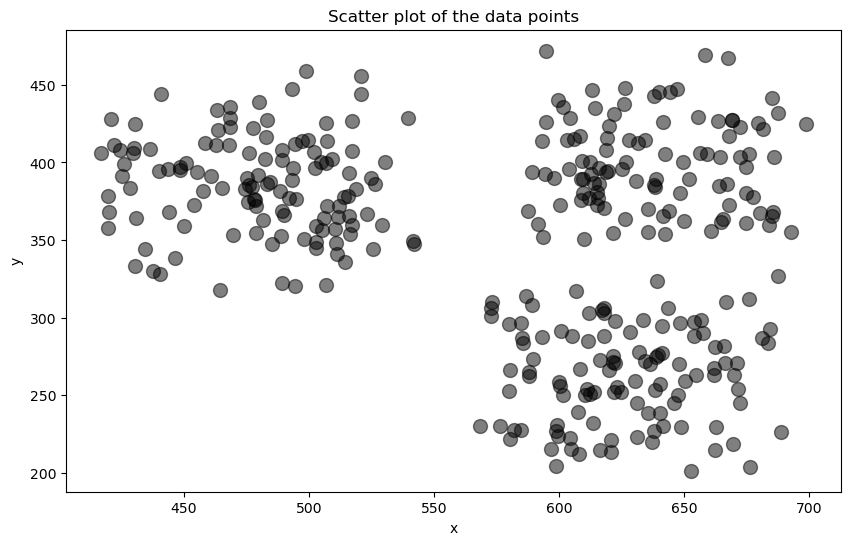

In [183]:
# Function to plot the data points of two features
def plot_data(data):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data.columns[0]], data[data.columns[1]], s=100, c='black', alpha=0.5)
    plt.title('Scatter plot of the data points')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

# Ploting the data points of two features
plot_data(data)

### Estandarización de los datos

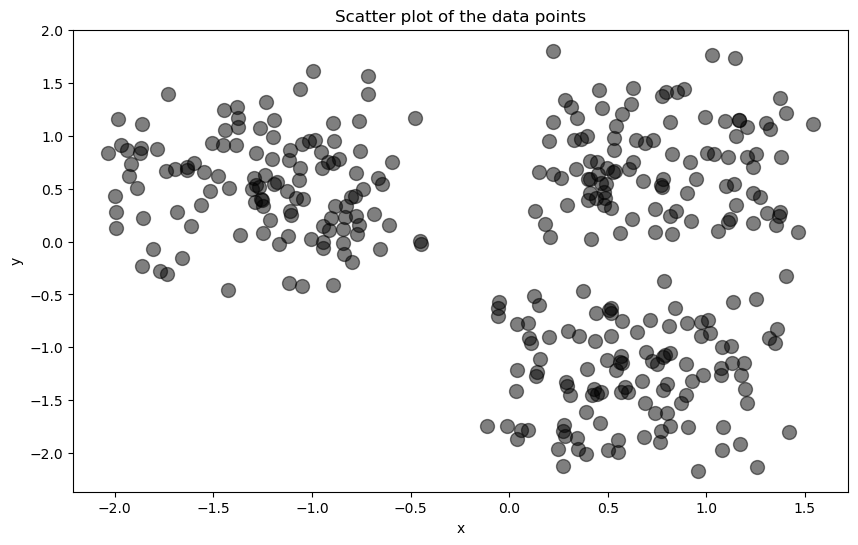

In [184]:
X = np.array(data)
standarized_data = StandardScaler().fit_transform(X=X)
standarized_df = pd.DataFrame(standarized_data, columns=data.columns)
plot_data(standarized_df)

## Método del codo

El método del codo o Elbow Method en inglés es utilizado para determinar el número óptimo de clusters en el que los datos pueden ser divididos.

In [185]:
# Code retrieved from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(standarized_data)
 
    distortions.append(sum(np.min(cdist(standarized_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / standarized_data.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(standarized_data, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / standarized_data.shape[0]
    mapping2[k] = kmeanModel.inertia_

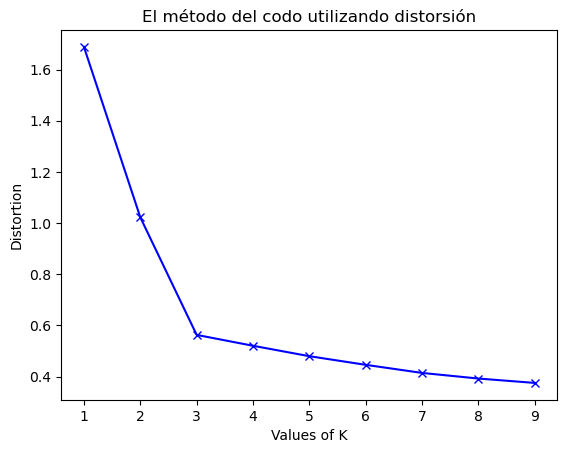

In [186]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('El método del codo utilizando distorsión')
plt.show()

## Implementación de K-means desde cero

### Inicialización de centroides

Uno de los primeros pasos para ejecutar el algoritmo de K-means es inicializar los centroides que no son más que puntos con $ d $ dimensiones que serán ubicados en el espacio de datos de manera aleatoria. Para ello procederemos a crear una matriz de dimensión $K \times d$ que contendrá los $ K $ centroides en donde cada fila representa un punto en la dimensión $d$.

In [187]:
# This value is obtained as a result of the elbow method
K = 3
performances = []

# Assigning random points to each centroid from the standarized data
centroids_df = standarized_df.sample(K)
centroids = np.array(centroids_df)

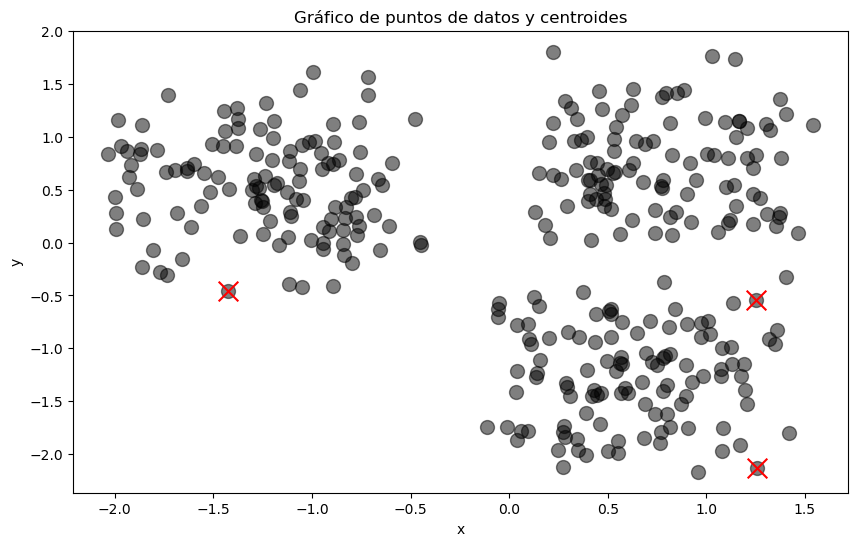

In [188]:
# Function to plot the data points of two features and the centroids
def plot_data_centroids(data, centroids):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[data.columns[0]], data[data.columns[1]], s=100, c='black', alpha=0.5)
    plt.scatter(centroids[centroids.columns[0]], centroids[centroids.columns[1]], c='red', s=200, marker='x')
    plt.title('Gráfico de puntos de datos y centroides')
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.show()

# Ploting the data points of two features and the centroids
plot_data_centroids(standarized_df, centroids_df)

### Distancia euclidiana

Para encontrar la distancia entre dos puntos $(x_{1}^{(1)}, x_{2}^{(1)})$,  $(x_{1}^{(2)}, x_{2}^{(2)})$ en donde solo hay dos dimensiones: $x_{1}$ y $x_{2}$, esta se calcula de la siguiente manera: 

$$ 
    \sqrt{(x_{1}^{(1)} - x_{1}^{(2)})^2 + (x_{2}^{(1)} - x_{2}^{(2)})^2} 
$$

Si se le agregan más dimensiones a ambos puntos por igual la distancia euclídea podrá ser calculada de la siguiente manera:
$$
    \sqrt{\sum_{i = 1}^d{(punto1 - punto2)^2}}
$$

Dado de que en la vida real se utilizan $ d $ dimensiones para entrenar un modelo, el código para calcular la distancia euclídea se ha realizado tomando en cuenta las siguientes características 
* La función recibe dos vectores con dimensiones $1 \times d$
* Cada vector representa un punto con $ d $ dimensiones

In [189]:
# Function for obtaining the result of the euclidean distance between two matrices
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

### Algoritmo de K-means

Este consiste en lo siguiente:
* Se asignan $ k $ puntos de manera aleatoria entre los puntos de los datos, estos representan los centroides de los clusters.
* Se calcula la distancia de todos los puntos con cada uno de los centroides y se asigna cada punto al cluster del centroide más cercano.
* Se calcula el promedio de cada cluster y los centroides son actualizados con los promedios de cada cluster.
* Se repite el proceso anterior hasta que el valor de los centroides no cambie. Esto indica que el algoritmo ha convergido.

In [190]:
def kmeans_from_scratch(X, K, centroids, max_iters):
    print(len(X))
    distances = np.zeros((len(X), K))
    cluster_assignments = np.zeros(len(X), dtype=int)
    new_centroids = np.zeros((K, len(X[0])))
    cluster_points = []

    for i in range(max_iters):

        # Assigning the X points to the closest centroid
        for i in range(len(X)): 
            for j in range(K): 
                distances[i][j] = euclidean_distance(X[i], centroids[j])
            cluster_assignments[i] = np.argmin(distances[i])

        # Creating clusters
        for i in range(K):
            for j in range(len(X)):
                if(cluster_assignments[j] == i):
                    cluster_points.append(X[j])
            # Updating the centroids
            new_centroids[i] = np.array(cluster_points).mean(axis=0)
            cluster_points = []

        centroids = new_centroids

        if(np.all(centroids == new_centroids)):
            break

    return centroids, cluster_assignments

336


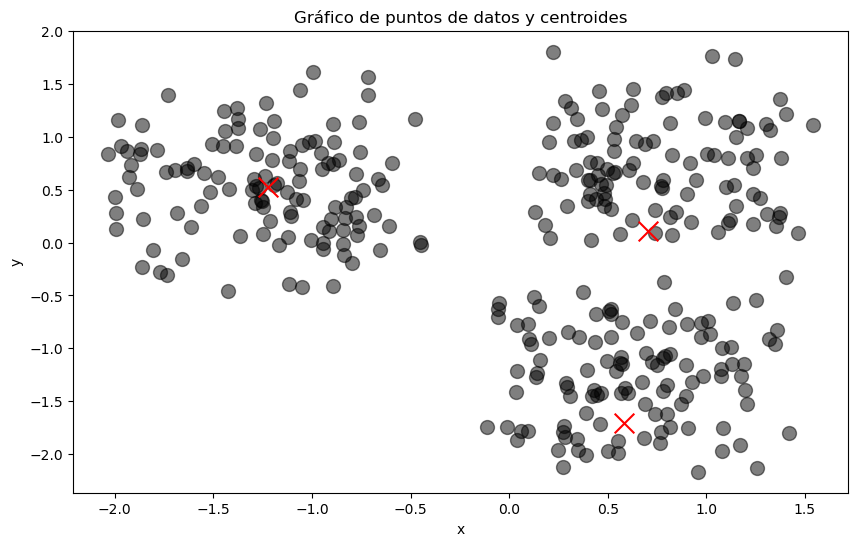

In [191]:
# Applying the K-means algorithm
centroids, labels = kmeans_from_scratch(standarized_data, K, centroids, 100000)
centroids_df = pd.DataFrame(centroids, columns=data.columns)

# Ploting the data points of two features and the centroids
plot_data_centroids(standarized_df, centroids_df)

### Evaluación del rendimiento

In [192]:
performances.append(metrics.silhouette_score(X, labels))
print(performances[0])

0.41787863632619127


## Implementación de K-means con scikit-learn

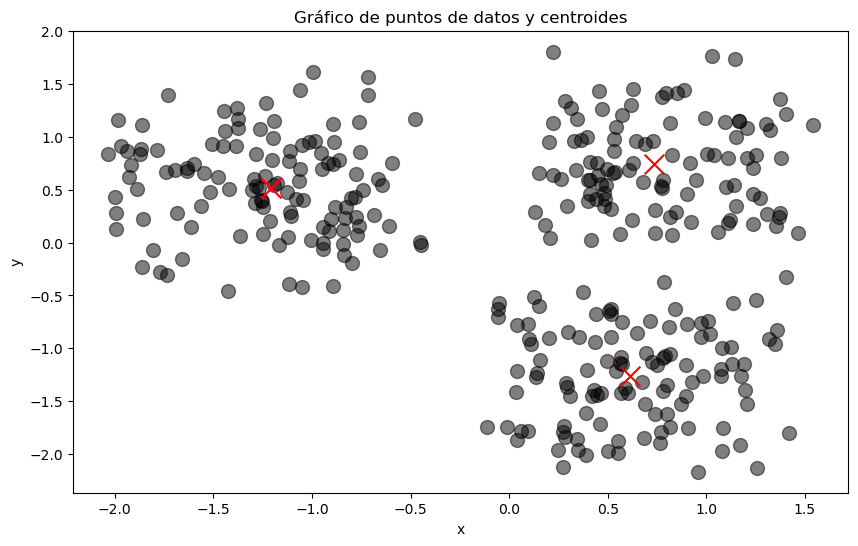

In [193]:
kmeans = KMeans(n_clusters=K, n_init='auto', max_iter=100000).fit(standarized_data)

plot_data_centroids(standarized_df, pd.DataFrame(kmeans.cluster_centers_, columns=data.columns))

### Evaluación del rendimiento

In [194]:
performances.append(metrics.silhouette_score(X, kmeans.labels_))
print(performances[1])

0.5899138564845062


## K-medoids

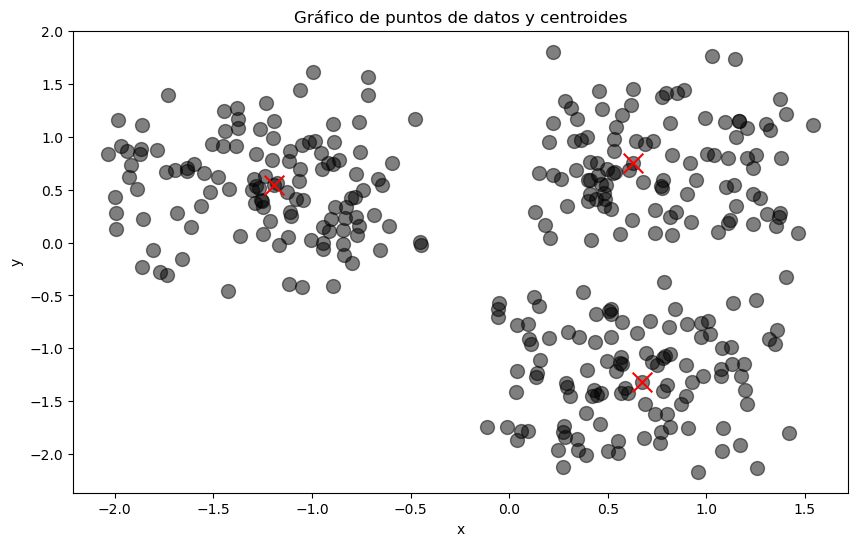

In [195]:
kmedoids = KMedoids(n_clusters=3, random_state=0).fit(standarized_data)

plot_data_centroids(standarized_df, pd.DataFrame(kmedoids.cluster_centers_, columns=data.columns))

### Evaluación del rendimiento

In [196]:
performances.append(metrics.silhouette_score(X, kmedoids.labels_))
print(performances[2])

0.5857271757236538


## Clustering Jerárquico

In [197]:
hierarchical = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(standarized_data)

In [200]:
# Code obtained from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

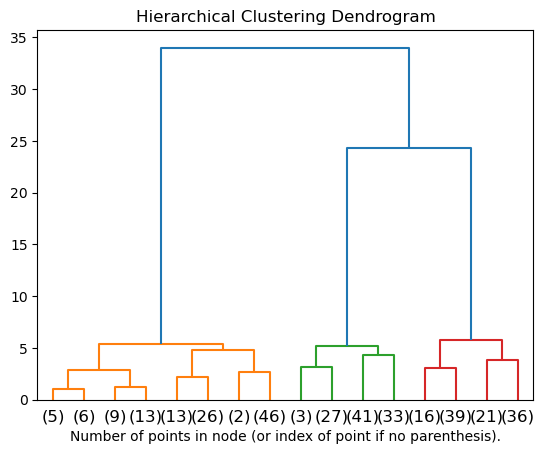

In [199]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(hierarchical, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Evaluación del rendimiento

In [204]:
""" performances.append(metrics.silhouette_score(X, hierarchical.labels_))
print(performances[3]) """
print(hierarchical.n_clusters_)

336
